In [1]:
import brainflow
import numpy as np
from brainflow.board_shim import BoardShim, BrainFlowInputParams
import time
from scipy import signal
import pyo as p
import threading
from ipywidgets import interact


WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter (if available).
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



In [2]:
def bandpass(start, stop, data, fs = 250, z=None):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(2, bp_Hz / (fs / 2.0), btype='bandpass')
    if isinstance(z,np.ndarray):
        zi = z
    else:
        zi = signal.lfilter_zi(b, a)
    return signal.lfilter(b, a, data, zi =zi, axis=0)

In [3]:
def bandstop(start, stop, data, fs = 250, z=None):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(2, bp_Hz / (fs / 2.0), btype='bandstop')
    if isinstance(z,np.ndarray):
        zi = z
    else:
        zi = signal.lfilter_zi(b, a)
    return signal.lfilter(b, a, data, zi =zi, axis=0)

In [4]:
class StreamFilter():
    def __init__(self, size=1, lcf = 2, hcf = 50, fs=250):
        self.buffer = np.array([0.0 for _ in range(size)])
        self.lcf = lcf
        self.hcf = hcf
        self.fs = fs
        self.zi_bp = None
        self.zi_bs = None
#         self.zi_hf = None
    def run(self,x):
        self.buffer = np.roll(self.buffer,-1)
        self.buffer[-1] = x
        y,z_bs = bandstop(60-3,60+3,self.buffer, self.fs, self.zi_bs)
        self.zi_bs = z_bs
        y,z_bp = bandpass(self.lcf,self.hcf,y, self.fs, self.zi_bp)
        self.zi_bp = z_bp
        return y[-1]
    
    def update(self, lcf=None, hcf=None, fs=None ):
        if lcf:
            self.lcf = lcf
        if hcf:
            self.hcf = hcf
        if fs:
            self.fs = fs

In [5]:
def start_board():
    params = BrainFlowInputParams ()
    params.serial_port = 'COM3'
    board = BoardShim(0,params)
    board.prepare_session ()
    board.start_stream (2)
    return board

In [6]:
def start_audio():
    s = p.Server(nchnls=1, sr=150000, buffersize=1024).boot()
    
    # sinusoidal oscillator (uncomment the line below and comment out the lines below it)
#     osc = p.SineLoop(freq=1).out()

    # filtered noise
    n = p.PinkNoise()
    osc = p.ButBP(n,q=10).out()
    
    
    
    #uncomment the lines below to record the audio in a wav file
#     s.recordOptions(dur=20, filename="./recording,wav", fileformat=0, sampletype=1)
#     s.recstart()

    s.start()
    return s,osc

In [7]:
# sonification parameters
a = 400
b = 400
c = 0
def param_update(A = a, B = b, C=c):
    global a,b,c
    a = A
    b = B
    c = C
#filter parameters
lcf=2
hcf=120
fs=250

def filter_update(LCF = lcf, HCF = hcf, FS = fs):
    global ff
    ff.update(lcf=LCF, hcf=HCF, fs=FS)

In [8]:
# start the board, this will not create a sound. for the sound you need to run the cells below
board = start_board()

In [9]:
ff = StreamFilter(lcf=2, hcf=120, fs=250)
raw = []
recording = []

def freq_update(r):
    global a,b,c,q, ff
    f = float(ff.run(r))
    # uncomment the lines below to record the raw signal or the filtered signal (recording)
#     raw.append(r) 
#     recording.append(f)
    osc.freq = float(b * np.exp(min( f/a , 4 ))) + c

def stream():
    global s,osc, board
    
    channel = 5 # the channel from which you are recording (N5P). Don't forget you need a bias channel too. 
    
    cd=board.get_current_board_data(1)[channel][0]
    try:
        while True:
            # whenever the value of the current board data is changed, update the frequency of the oscillator
            ncd=board.get_current_board_data(1)[channel][0]
            if ncd!=cd:
                cd = ncd
                freq_update(cd)

    except KeyboardInterrupt:
        print("Press Ctrl-C to terminate while statement")
        s.stop()

In [10]:
# start an oscillator
s,osc = start_audio()

In [11]:
# run to modulate the sound with the data from the board
st = threading.Thread(target=stream, daemon=True)
st.start()

In [12]:
# run to change the parameters of audio
interact(param_update, A=(1,400,0.1), B=(200.,500.,0.1), C=(0,300,0.1));

interactive(children=(FloatSlider(value=400.0, description='A', max=400.0, min=1.0), FloatSlider(value=400.0, …

In [13]:
# run to change the filter parameters
interact(filter_update, LCF=(0.1,124,0.1), HCF=(0.2,120,0.1), FS=(125,500,0.1));

interactive(children=(FloatSlider(value=2.0, description='LCF', max=124.0, min=0.1), FloatSlider(value=120.0, …

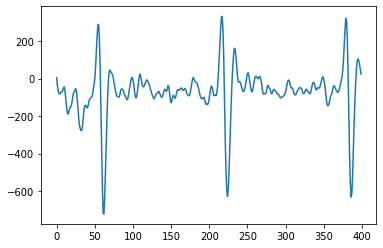

In [32]:
# #to plot the recording you can use this
# import matplotlib.pyplot as plt
# plt.plot(recording[600:1000])

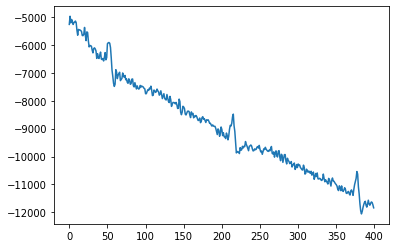

In [33]:
# plt.plot(raw[600:1000])